In [1]:
from sklearn import svm,metrics,model_selection
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import feature

# LOADING DATA

In [2]:
data = pd.read_csv("train.csv")
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
images = data.ix[:, 1:].as_matrix().reshape((-1,28,28))
labels = data.ix[:, 0].as_matrix()

In [4]:
def show_img(image):
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

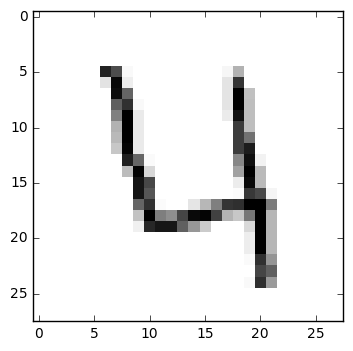

In [5]:
show_img(images[3])

## Setup training and testing data

In [6]:
sample_df = data.sample(13000)
training_df = sample_df[:10000]
testing_df = sample_df[10000:]

In [7]:
training_data = training_df.ix[:, 1:].as_matrix()
training_labels = training_df.ix[:, 0].as_matrix()

In [8]:
test_data = testing_df.ix[:, 1:].as_matrix()
test_labels = testing_df.ix[:, 0].as_matrix()

# Feature Extraction

## HOG function

In [9]:
from sklearn.externals import joblib
from skimage.feature import hog
from time import time

In [40]:
def hog_features_extraction(features):
    t0 = time()
    list_hog_fd = []
    for feature in features:
        fd = hog(feature.reshape((28,28)), orientations = 9, pixels_per_cell=(7,7), cells_per_block=(1,1), visualise=False)
    #     print(fd.shape)
        list_hog_fd.append(fd)

    hog_features = np.array(list_hog_fd,'float64')
#     print(hog_features.shape)
#     print('HOG Extraction time consuming:', (time()-t0))
    return hog_features

In [44]:
def classify_reduce_PCA(r_dimension,train_HOG_features,test_HOG_features):
    print("Reduce to %d dimension"%r_dimension)
    print("=========================================\n")
    result = dict()
    t0 = time()
    reducer = decomposition.PCA(n_components = r_dimension)
    reducer.fit(train_HOG_features)
    print('Setting up PCA - consumed time:',(time()-t0))

    t0 = time()
    train_reduced_features = reducer.transform(train_HOG_features)
#     print(np.shape(train_reduced_features))
    print('Reducing training data - consumed time:',(time()-t0))
    result['train_reduct'] = (time()-t0)

    t0 = time()
    test_reduced_features = reducer.transform(test_HOG_features)
#     print(np.shape(test_reduced_features))
    print('Reducing testing data - consumed time:',(time()-t0))
    result['test_reduct'] = (time()-t0)


    t0=time()
    classifier_LLE = svm.SVC(decision_function_shape="ovr", gamma="auto")
    classifier_LLE.fit(train_reduced_features, training_labels)
    print('Training Classifier - consumed time:', time()-t0)
    result['train_classifier'] = (time()-t0)

    # # Test With Reduction

    # In[20]:

    t0=time()
    predicted = classifier_LLE.predict(test_reduced_features)
    print('Testing Classifier - consumed time:', time()-t0)
    result['test_classifier'] = (time()-t0)
    print("=========================================\n")
    # In[21]:
    classifier_result = metrics.classification_report(test_labels, predicted)
    print(metrics.classification_report(test_labels, predicted))
    return (result,classifier_result)

## HOG Extraction

In [11]:
train_HOG_features = hog_features_extraction(training_data)
test_HOG_features = hog_features_extraction(test_data)

(10000, 144)
HOG Extraction time consuming: 2.6725330352783203
(3000, 144)
HOG Extraction time consuming: 0.8001182079315186


# Classification

In [12]:
t0 = time()
classifier = svm.SVC(decision_function_shape="ovr", gamma="auto")
classifier.fit(train_HOG_features, training_labels)
print('Classification Consuming:',(time()-t0))

Classification Consuming: 16.404961109161377


### Testing

In [13]:
t0 = time()
predicted = classifier.predict(test_HOG_features)
print('Test time:',(time()-t0))

Test time: 3.8945019245147705


In [14]:
print(metrics.classification_report(test_labels, predicted))

             precision    recall  f1-score   support

          0       0.91      0.96      0.93       299
          1       0.93      0.97      0.95       335
          2       0.94      0.91      0.93       321
          3       0.89      0.92      0.91       303
          4       0.93      0.90      0.91       257
          5       0.95      0.90      0.92       257
          6       0.95      0.94      0.94       304
          7       0.95      0.85      0.90       326
          8       0.93      0.90      0.91       306
          9       0.81      0.93      0.87       292

avg / total       0.92      0.92      0.92      3000



# Dimensionality Reduction

## PCA

## Configuration

In [15]:
from sklearn import decomposition

In [16]:
t0 = time()
reducer = decomposition.PCA(n_components=64)
reducer.fit(train_HOG_features)
print('Consumed time:',(time()-t0))

Consumed time: 0.2348160743713379


## Reduction

In [17]:
t0 = time()
train_reduced_features = reducer.transform(train_HOG_features)
print(np.shape(train_reduced_features))
print('Consumed time:',(time()-t0))

(10000, 64)
Consumed time: 0.013130903244018555


In [18]:
t0 = time()
test_reduced_features = reducer.transform(test_HOG_features)
print(np.shape(test_reduced_features))
print('Consumed time:',(time()-t0))

(3000, 64)
Consumed time: 0.003966808319091797


# Classification With Reduction

In [19]:
t0=time()
classifier_LLE = svm.SVC(decision_function_shape="ovr", gamma="auto")
classifier_LLE.fit(train_reduced_features, training_labels)
print('SVM time consuming:', time()-t0)

SVM time consuming: 4.236742973327637


# Test With Reduction

In [20]:
t0=time()
predicted = classifier_LLE.predict(test_reduced_features)
print('Test time:', time()-t0)

Test time: 1.6038048267364502


In [21]:
print(metrics.classification_report(test_labels, predicted))

             precision    recall  f1-score   support

          0       0.94      0.95      0.95       299
          1       0.93      0.97      0.95       335
          2       0.93      0.91      0.92       321
          3       0.90      0.91      0.90       303
          4       0.94      0.90      0.92       257
          5       0.96      0.91      0.93       257
          6       0.95      0.94      0.95       304
          7       0.94      0.89      0.91       326
          8       0.93      0.91      0.92       306
          9       0.84      0.92      0.88       292

avg / total       0.92      0.92      0.92      3000



## Calibrate parameter of PCA to get better result

In [50]:
metrix,result = classify_reduce_PCA(34,train_HOG_features,test_HOG_features)

Reduce to 34 dimension

Setting up PCA - consumed time: 0.1390230655670166
Reducing training data - consumed time: 0.00798797607421875
Reducing testing data - consumed time: 0.0025010108947753906
Training Classifier - consumed time: 2.153532028198242
Testing Classifier - consumed time: 0.8863651752471924

             precision    recall  f1-score   support

          0       0.93      0.95      0.94       299
          1       0.93      0.97      0.95       335
          2       0.91      0.89      0.90       321
          3       0.88      0.89      0.89       303
          4       0.92      0.89      0.91       257
          5       0.94      0.92      0.93       257
          6       0.94      0.94      0.94       304
          7       0.94      0.89      0.91       326
          8       0.91      0.88      0.89       306
          9       0.85      0.92      0.88       292

avg / total       0.92      0.92      0.91      3000



# END